In [50]:
library(tidyverse)
source("../scripts//assembly-map.r")

In [51]:
sim_number_to_directory <- function(sim_num){
    sim_dir = paste0("../data/sims/",sim_num, "/")
    return(sim_dir)
}

In [70]:
simulation_number <- 16117
ts_data <- read.csv(paste0(sim_number_to_directory(simulation_number),"timeseries.csv"))
ts_data <- ts_data %>% filter(value > 1)

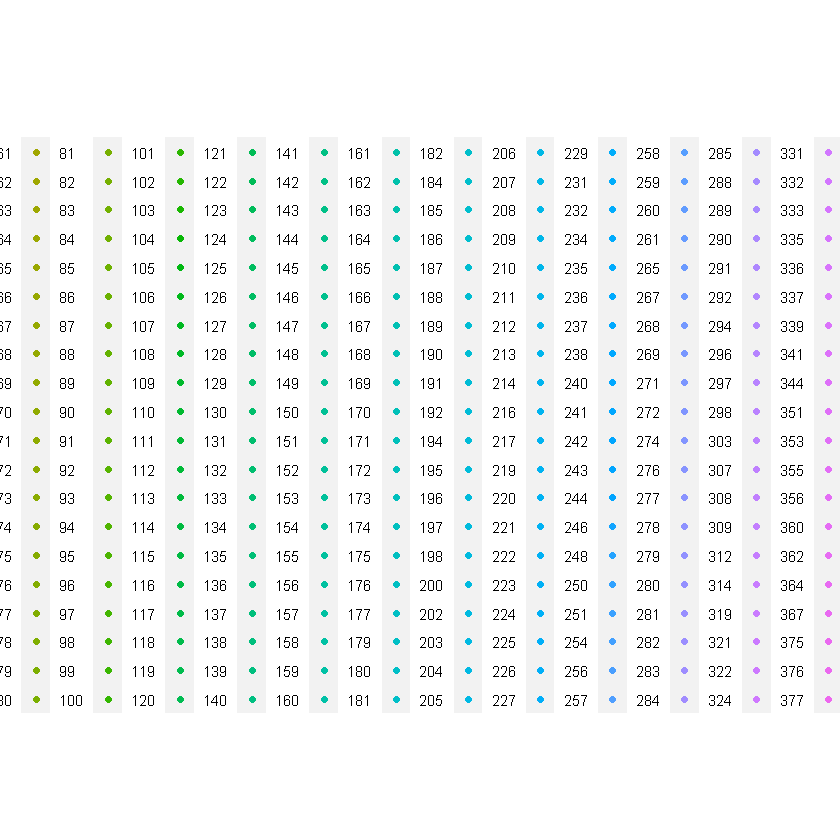

In [71]:
#ts_data <- ts_data %>% filter(reactor == 2)
ggplot(ts_data) +
    geom_point(aes(x = time, y = value, color  = as.factor(variable))) + 
    facet_wrap(~reactor) +
    scale_y_log10()

In [72]:
ts_data$AI <- assembly_index(ts_data$variable)

In [73]:
max(ts_data$variable)
ai_ts_data <- ts_data %>% group_by(AI, time, reactor) %>% summarise(value = sum(value))

[1] 4159

`summarise()` has grouped output by 'AI', 'time'. You can override using the `.groups` argument.


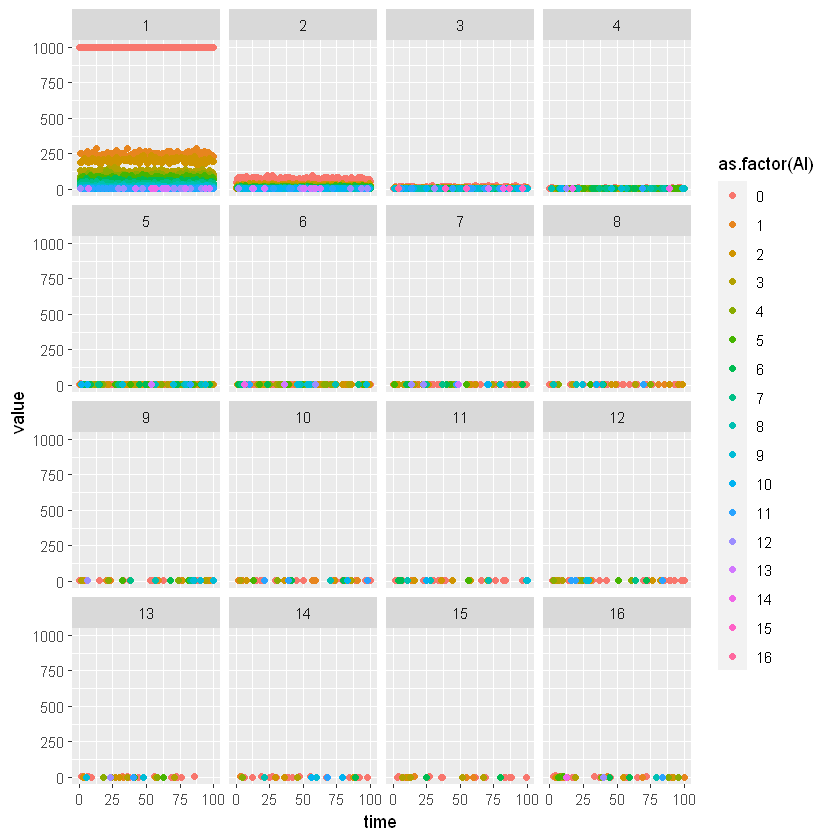

In [74]:
ggplot(ai_ts_data) +
    geom_point(aes(x = time, y = value, color  = as.factor(AI))) + 
    facet_wrap(~reactor) 

In [77]:
sum_over_reactors <- function(timeseries_data){
    average_data <- timeseries_data %>% 
                        group_by(variable, time) %>%
                        summarise(total_value = sum(value))
    return(average_data)
}
average_data <- ts_data %>% group_by(variable, time) %>% summarise(total_value = sum(value))

`summarise()` has grouped output by 'variable'. You can override using the `.groups` argument.


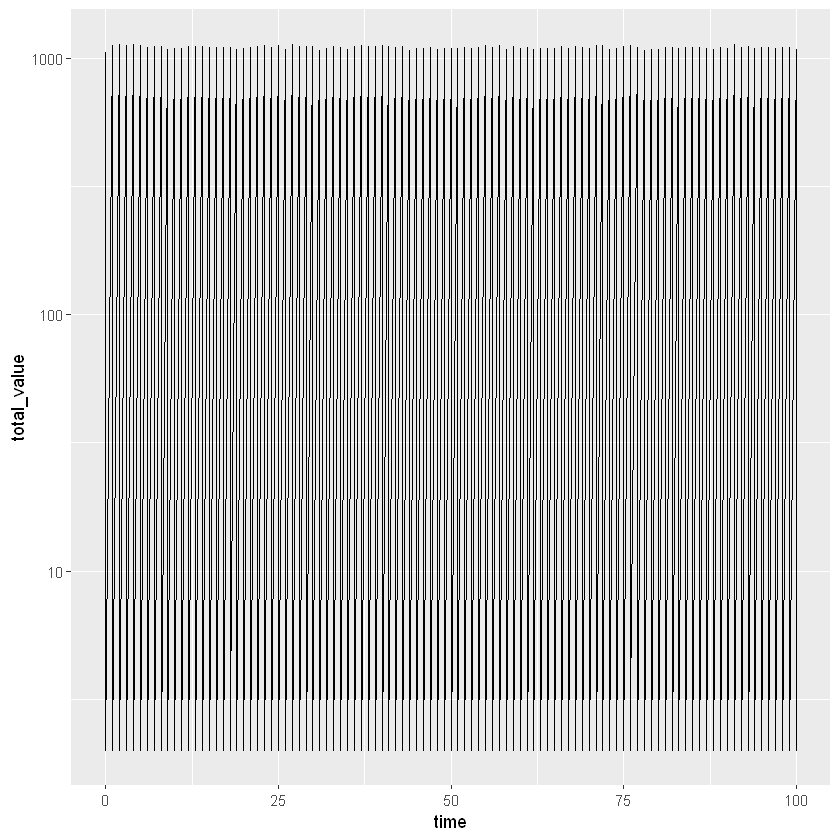

In [78]:
average_data <- average_data %>% filter(total_value > 1)
ggplot(average_data) + geom_line(aes(x = time, 
                                      y = total_value,
                                      )) + 
                        scale_y_log10()

In [79]:
end_data <- average_data %>% filter(time == 100.0)

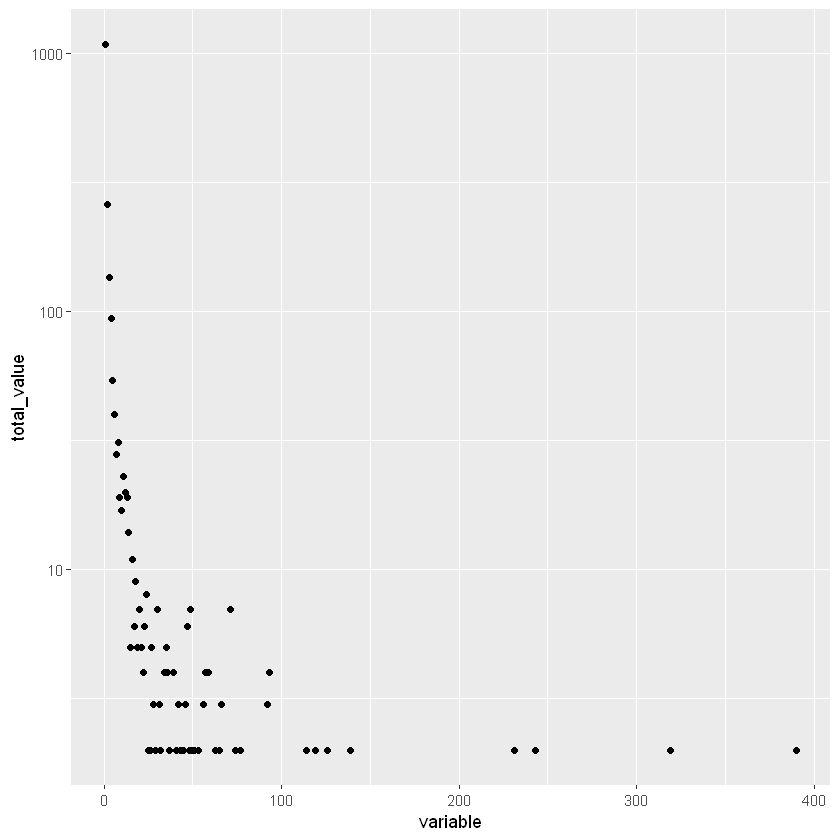

In [80]:
#end_data
ggplot(end_data) + geom_point(aes(x = variable, y  = total_value)) + scale_y_log10()

In [67]:
r2glm <- function(model) {

  summaryLog <- summary(model)
  1 - summaryLog$deviance / summaryLog$null.deviance

}

get_exp_fit_from_sim <- function(sim_number){
    # Get the slope, confidence interval and simulated R2 from an exponential fit like 
    # total_count ~ exp(AI) (or log(total_count) ~ AI)
    # sum over all reactors before fitting 
    ts_data <- read.csv(paste0(sim_number_to_directory(sim_number),"timeseries.csv"))
    average_data <- sum_over_reactors(ts_data)
    average_data <- average_data %>% filter(total_value > 1)
    # Get only the last time point TODO: come back and decide if averaging here makes sense
    max_time <- max(average_data$time)
    end_time <- average_data %>% filter(time == max_time)
    end_time$AI <- assembly_index(end_time$variable)
    # Group all compounds by assembly index
    total_AI_counts <- end_time %>% group_by(AI) %>% summarise(total_count = sum(total_value))
    if (nrow(total_AI_counts) > 3) {
        # If there's more than 3 assembly numbers present
        fit.model <- glm(log(total_count) ~ AI, data = total_AI_counts)
        # Extract fit coefficient and R^2
        alpha <- as.numeric(fit.model$coefficients["AI"])
        r2 <- r2glm(fit.model)
        # Calculate confidence intervals
        confidence_intervals <- confint(fit.model)
        alpha.minus <- confidence_intervals[2,1]
        alpha.plus <- confidence_intervals[2,2]
    }
    # If there's not enough data return NA
    else{
        alpha <- NA
        alpha.minus <- NA
        alpha.plus <- NA
        r2 <- NA
        
    }

    results = list(alpha = alpha, 
                   alpha.minus = alpha.minus,
                   alpha.plus = alpha.plus,
                   r2 = r2)
    return(results)

}

In [75]:
mod <- get_exp_fit_from_sim(16117)

`summarise()` has grouped output by 'variable'. You can override using the `.groups` argument.
Waiting for profiling to be done...



In [76]:
mod

$alpha
[1] -0.3635537

$alpha.minus
[1] -0.4152826

$alpha.plus
[1] -0.3118248

$r2
[1] 0.9312862

In [52]:
c <- confint(mod)
c

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),3.5006642,4.2609275
AI,-0.3930036,-0.2706925


In [57]:
c[2,1]

[1] -0.3930036